In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import contextily as cx
import plotly
from sklearn.metrics import mean_absolute_percentage_error

In [25]:
def tractLevelMap(geo_df, colorCol, saveAddr, colorScale = 'Blues', colorRange = (0, 10000)):
    fig = px.choropleth_mapbox(geo_df,
                               geojson = geo_df.geometry,
                               locations = geo_df.index,
                               color = colorCol,
                               color_continuous_scale = colorScale,
                               mapbox_style = "carto-positron",
                               center = {"lat": 33.826512, "lon": -118.228486},
                               opacity = 0.6,
                               width = 650,
                               height = 1000,
                               range_color = colorRange,
                              )
    fig.update_geos(fitbounds = "locations", visible = False)
    fig.write_html(saveAddr)

In [2]:
# get data on tracts level
tracts_estimate = pd.read_csv('./saved/estimates_tracts/energyElec_biLSTM_2023-07-21-21-39-29/tractsDF.csv').drop('Unnamed: 0', axis = 1)
tracts_estimate.geoid = tracts_estimate.geoid.astype(str)

In [3]:
# get tracts geometry
tracts_geo = gpd.read_file('./data/geo_data/tract.geojson')
tracts_geo['id.tract'] = tracts_geo['id.tract'].str[1:]

In [26]:
tractLevelTargetMap(tracts_geo[['id.tract', 'geometry']].merge(tracts_estimate[tracts_estimate.timestamp == '2018-11-01 13:00:00'][['geoid', 'estimate']], 
                                                               how = 'left',
                                                               left_on = 'id.tract',
                                                               right_on = 'geoid',
                                                              ).set_index('geoid'), 
               "estimate", 
               './saved/estimates_tracts/energyElec_biLSTM_2023-07-21-21-39-29/tractEstimationMap_110113.html')

In [27]:
tractLevelTargetMap(tracts_geo[['id.tract', 'geometry']].merge(tracts_estimate[tracts_estimate.timestamp == '2018-08-01 13:00:00'][['geoid', 'estimate']], 
                                                               how = 'left',
                                                               left_on = 'id.tract',
                                                               right_on = 'geoid',
                                                              ).set_index('geoid'), 
               "estimate", 
               './saved/estimates_tracts/energyElec_biLSTM_2023-07-21-21-39-29/tractEstimationMap_080113.html')

In [ ]:
vis_tractLevel_mape(tracts_geo[['id.tract', 'geometry']].merge(tracts_estimate.groupby('geoid').apply(lambda g: mean_absolute_percentage_error(g.true, g.estimate)).to_frame('mape').reset_index(), 
                                                               how = 'left',
                                                               left_on = 'id.tract',
                                                               right_on = 'geoid',
                                                              ).set_index('geoid'), 
                    'mape', 
                    './saved/estimates_tracts/energyElec_biLSTM_2023-07-21-21-39-29/coolingLoad_mape.html')

In [107]:
def vis_climateCoor(climateID, dir_corrMatrix):
    # get climate zone geo
    climateZone = gpd.read_file('./data/geo_data/coarse_grid.geojson')
    climateZone['id.grid.coarse'] = climateZone['id.grid.coarse'].astype(int)
    climateZone_geo = climateZone[['id.grid.coarse', 'geometry']]
    # get coor for selected climate zone
    climateCorr = pd.read_csv(dir_corrMatrix).set_index('Climate')
    climateCorrSelect = climateCorr[climateCorr.index == climateID].T.reset_index().rename({'index': 'climate', 
                                                                                            climateID: 'corr'}, axis = 1)
    climateCorrSelect.climate = climateCorrSelect.climate.astype(int)
    # merge
    climate_merged = climateZone_geo.merge(climateCorrSelect, how = 'right', right_on = 'climate', left_on = 'id.grid.coarse')
    # vis
    climate_merged.plot(column = 'corr')

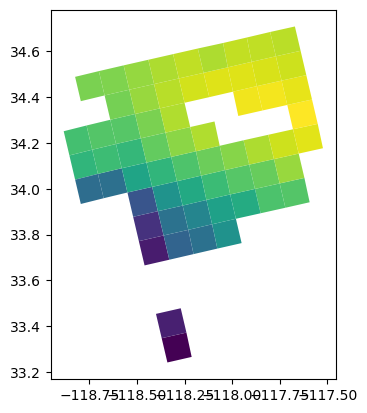

In [193]:
vis_climateCoor(pd.read_csv('./saved/climateCorr/climateCorr.csv').Climate.unique().tolist()[15], 
                './saved/climateCorr/climateCorr.csv')